<a href="https://colab.research.google.com/github/Pravinoraon/capstone/blob/main/Notebook%204%3A%20Convert%20Model%20%26%20Deploy%20for%20Android%20(TFLite%20Conversion).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import tensorflow as tf
import os
from google.colab import drive


In [39]:
# Mount Google Drive
drive.mount('/content/drive')

# Load trained model
model_path = "/content/drive/MyDrive/bell_pepper_data/bell_pepper_disease_model.h5"  # Update if different
model = tf.keras.models.load_model(model_path)

print("Model loaded successfully!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Model loaded successfully!


In [40]:
# Convert model to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Optimize for size and speed
tflite_model = converter.convert()

# Save converted model
tflite_model_path = "/content/drive/MyDrive/bell_pepper_data/bell_pepper_model.tflite"
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

print(f"TFLite model saved at: {tflite_model_path}")


Saved artifact at '/tmp/tmp7pohfvlo'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_3')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  137525126411088: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  137525126412816: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  137525126411856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137525126403216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137525126400528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137525126402640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137525126412240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137525126398416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137525126399568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137525126401104: TensorSpec(shape=(), dtype=tf.resource, name=Non

In [41]:
# Load TFLite model
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("TFLite Model Loaded Successfully!")
print("Input Details:", input_details)
print("Output Details:", output_details)


TFLite Model Loaded Successfully!
Input Details: [{'name': 'serving_default_input_layer_3:0', 'index': 0, 'shape': array([  1, 224, 224,   3], dtype=int32), 'shape_signature': array([ -1, 224, 224,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output Details: [{'name': 'StatefulPartitionedCall_1:0', 'index': 485, 'shape': array([1, 1], dtype=int32), 'shape_signature': array([-1,  1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [42]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

IMG_SIZE = (224, 224)

def predict_tflite(image_path, interpreter):
    img = load_img(image_path, target_size=IMG_SIZE)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Set input tensor
    input_tensor_index = input_details[0]['index']
    interpreter.set_tensor(input_tensor_index, img_array.astype(np.float32))

    # Run inference
    interpreter.invoke()

    # Get output tensor
    output_tensor_index = output_details[0]['index']
    prediction = interpreter.get_tensor(output_tensor_index)[0][0]
    category = "Diseased" if prediction > 0.5 else "Healthy"

    plt.imshow(img)
    plt.title(f"Predicted: {category} ({prediction:.2f})")
    plt.axis('off')
    plt.show()


Diseased Images: ['image (929).JPG', 'image (15).JPG', 'image (342).JPG', 'image (426).JPG', 'image (553).JPG']
Healthy Images: ['image (1361).JPG', 'image (1209).JPG', 'image (1007).JPG', 'image (856).JPG', 'image (635).JPG']


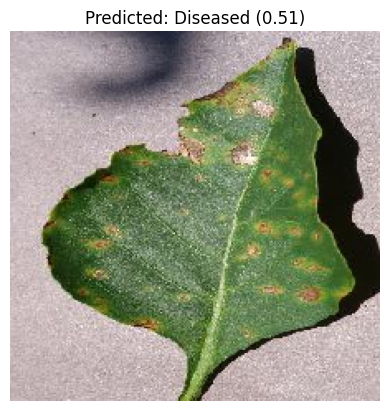

In [43]:
# Check available images in validation folder
val_diseased_dir = "/content/drive/MyDrive/bell_pepper_data/val/Diseased"
val_healthy_dir = "/content/drive/MyDrive/bell_pepper_data/val/Healthy"

print("Diseased Images:", os.listdir(val_diseased_dir)[:5])
print("Healthy Images:", os.listdir(val_healthy_dir)[:5])

# Select an image for testing
test_image_name = os.listdir(val_diseased_dir)[0]  # Pick first image
test_image_path = os.path.join(val_diseased_dir, test_image_name)

# Predict with TFLite model
predict_tflite(test_image_path, interpreter)
